# LightGBM

Script com foco no processo de forecast com previsão multi-step. <br>Método: direct prediction (ver https://machinelearningmastery.com/multi-step-time-series-forecasting/)


In [1]:
#https://www.youtube.com/watch?v=fG8H-0rb0mY
#https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import lightgbm as lgb
#lgb.__version__

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use('fivethirtyeight') # estilo dos gráficos
rcParams['figure.figsize'] = 15, 5 # tamanho das figuras

In [3]:
def load_data():
    """
    Função para ler e transformar os dados já presentes no diretório especificado
    """
    path = "../data/daily_load.csv"
    df_load = pd.read_csv(path, parse_dates = ["date"])
    df_load2 = df_load[df_load["id_reg"] == "S"]           # região sul
    df_load3 = df_load2[df_load2["date"] <= '2022-05-31']  # data de corte
    df_load4 = df_load3[["date", "load_mwmed"]].set_index("date")
    return df_load4

def train_test_split(data, n_test):
    """
    Função para partir or dados em treino e teste
    """
    if isinstance(data, pd.DataFrame):
        train, test = data.iloc[:-n_test, :], data.iloc[-n_test:, :]
    elif isinstance(data, np.ndarray):
        train, test = data[:-n_test, :], data[-n_test:, :]
    return train, test

# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

def lightgbm_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = lgb.LGBMRegressor(objective='regression', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = lightgbm_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected = %.1f, predicted = %.1f' % (testy, yhat))
    # estimate prediction error
    mae = mean_absolute_error(test[:, -1], predictions)
    mape = mean_absolute_percentage_error(test[:, -1], predictions)
    rmse = np.sqrt(mean_squared_error(test[:, -1], predictions))    
    return mae, mape, rmse, test[:, -1], predictions

def get_measures(forecast, test):
    """
    Função para obter medidas de acurária a partir dos dados de projeção e teste
    """
    #forecast.reset_index(drop = True, inplace = True)
    #test.reset_index(drop = True, inplace = True)
    #errors = [(test.iloc[i] - forecast.iloc[i])**2 for i in range(len(test))]
    if isinstance(forecast, pd.Series) and isinstance(test, pd.Series):
        errors = [(test.iloc[i] - forecast.iloc[i])**2 for i in range(len(test))]
    # else:
    #     errors = [(test.iloc[i][0] - forecast.iloc[i])**2 for i in range(len(test))]
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test, forecast)
    # smape
    a = np.reshape(test.values, (-1,))
    b = np.reshape(forecast.values, (-1,))
    smape = np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()
    # dicionário com as medidas de erro
    measures = { "erro": sum(errors),
                 "mae": mae,
                 "mse": mse,
                 "rmse": rmse,
                 "mape": mape,
                 "smape": smape
                }
    # arredondamento
    # for key, item in measures.items():
    #     measures[key] = round(measures[key], 2)
    return measures


# Usando SKTIME para projetar

In [4]:
df = load_data()
df.interpolate(method = "linear", inplace = True)

In [5]:
df_sk = df.asfreq('D')
df_sk.head()

,load_mwmed
date,
2000-01-01,4800.650000
2000-01-02,4899.800000
2000-01-03,6261.554167
2000-01-04,6733.741667
2000-01-05,6961.170833


In [6]:
n_test = 10
X, y = train_test_split(df_sk, n_test) # split partitions

In [7]:
#https://towardsdatascience.com/multi-step-time-series-forecasting-with-arima-lightgbm-and-prophet-cc9e3f95dfb0

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV

regressor = lgb.LGBMRegressor()
forecaster = make_reduction(regressor, window_length=60, strategy="recursive")
forecaster.fit(X)   # fit 
forecaster.predict(fh = [x for x in range(1,n_test + 1)])    # forecast three days ahead

,load_mwmed
2022-05-22,8945.294801
2022-05-23,11716.222344
2022-05-24,12023.280010
2022-05-25,12047.558935
2022-05-26,11899.052396
2022-05-27,11931.996763
2022-05-28,10331.229395
2022-05-29,8786.639132
2022-05-30,11563.565119
2022-05-31,11801.086979


Grid search for LighGBM

In [283]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

In [ ]:
def create_forecaster():
    
    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
    
    return forecaster

def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")
    
    # forecasting
    fh=np.arange(len(test))+1
    y_pred = gscv.predict(fh=fh)
    mae, mape = plot_forecast(train, test, y_pred)

    return mae, mape
    
param_grid = {"window_length": [5, 10, 15, 20, 25, 30]} # parameter set to be grid searched
forecaster = create_forecaster()
sun_lgb_mae, sun_lgb_mape = grid_serch_forecaster(X, y, forecaster, param_grid)

# MANUALMENTE

In [8]:
df = load_data()
df.interpolate(method = "linear", inplace = True)
values = df.values.tolist()
lag = 60 
outs = 10
data = series_to_supervised(values, n_in = lag, n_out = outs, dropnan=False)

In [9]:
# DATA DA ÚLTIMA LINHA EM "data"
df[df.load_mwmed == data["var1(t)"].iloc[-1]]

,load_mwmed
date,
2022-05-31,12162.756792


In [16]:
n_test = 10
train, test = train_test_split(data, n_test)
train.dropna(inplace = True)

In [17]:
# DATA DA ÚLTIMA LINHA EM "data"
df[df.load_mwmed == train["var1(t)"].iloc[-1]]

,load_mwmed
date,
2022-05-21,10256.970375


In [18]:
# EXEMPLO 1: t+3
# ÚLTIMO VALOR EM var1(t+h) DEVE SER O MESMO PARA TODAS ESTIMAÇÕES
# PARA VISUALIZAR MELHOR, OLHAR EXCEL "multistep" NA PASTA "DATA"
# response_vars = data.columns[-(outs):]
# cols = [x for x in data.columns[:lag]]
# h = 3 # t + h model
# cols.append(f"var1(t+{h})")
# data_ = train[cols]
# data_ = data_.iloc[:-h, :] # t - h, because we only have data up to T
# data_X, data_y = data_.iloc[:, :-1], data_.iloc[:, -1]
# model = lgb.LGBMRegressor(objective='regression', n_estimators=1000)
# model.fit(data_X, data_y)
# teste = train.loc[:, :"var1(t-1)"].iloc[-1,:] # uses the last available observations to predict t + h
# model.predict([teste])

In [19]:
train

,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9)
60,4800.650000,4899.800000,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,...,7344.591667,7500.862500,7428.862500,6430.975000,5449.625000,6348.716667,6131.350000,6789.962500,7020.404167,7106.220833
61,4899.800000,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,...,7500.862500,7428.862500,6430.975000,5449.625000,6348.716667,6131.350000,6789.962500,7020.404167,7106.220833,6348.400000
62,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,...,7428.862500,6430.975000,5449.625000,6348.716667,6131.350000,6789.962500,7020.404167,7106.220833,6348.400000,5342.358333
63,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,...,6430.975000,5449.625000,6348.716667,6131.350000,6789.962500,7020.404167,7106.220833,6348.400000,5342.358333,7035.900000
64,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,7532.275000,...,5449.625000,6348.716667,6131.350000,6789.962500,7020.404167,7106.220833,6348.400000,5342.358333,7035.900000,7364.441667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8173,14198.562958,11296.964583,9206.600458,11830.310375,12475.772542,12928.446208,12481.912583,11564.961500,9796.231333,8644.748083,...,11964.909375,12269.051375,12021.415458,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708
8174,11296.964583,9206.600458,11830.310375,12475.772542,12928.446208,12481.912583,11564.961500,9796.231333,8644.748083,12049.438875,...,12269.051375,12021.415458,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833
8175,9206.600458,11830.310375,12475.772542,12928.446208,12481.912583,11564.961500,9796.231333,8644.748083,12049.438875,12864.373792,...,12021.415458,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833,10525.490875
8176,11830.310375,12475.772542,12928.446208,12481.912583,11564.961500,9796.231333,8644.748083,12049.438875,12864.373792,12801.830000,...,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833,10525.490875,9074.211250


In [34]:
# FOR LOOP (MELHORAR)
response_vars = data.columns[-(outs):]

predictions = list()
for h, response in enumerate(response_vars):
    cols = [x for x in data.columns[:lag]]
    if h == 0:
        cols.append("var1(t)")
        data_ = train[cols]
        data_ = data_.iloc[:, :]        
    else:
        cols.append(f"var1(t+{h})")
    data_ = train[cols]
    nrows = data_.shape[0]
    data_ = data_.iloc[:nrows-h, :] 
    data_X, data_y = data_.iloc[:, :-1], data_.iloc[:, -1]
    model = lgb.LGBMRegressor(objective='regression', n_estimators=1000)
    model.fit(data_X, data_y)
    teste = train.loc[:, :"var1(t-1)"].iloc[-1,:] # t + 3 (observado = 12.054,20)
    pred = model.predict([teste])[0]
    print(pred)
    predictions.append((h, pred))

10285.883913939027
8949.101203973765
11555.944895477676
11577.011322779696
12110.284326361201
11842.924460430644
12272.798204323499
9923.401389386623
9186.951069300245
11158.090977791611


In [20]:
n_test = 10
train, test = train_test_split(data, n_test)
train.dropna(inplace = True)
train

,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9)
60,4800.650000,4899.800000,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,...,7344.591667,7500.862500,7428.862500,6430.975000,5449.625000,6348.716667,6131.350000,6789.962500,7020.404167,7106.220833
61,4899.800000,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,...,7500.862500,7428.862500,6430.975000,5449.625000,6348.716667,6131.350000,6789.962500,7020.404167,7106.220833,6348.400000
62,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,...,7428.862500,6430.975000,5449.625000,6348.716667,6131.350000,6789.962500,7020.404167,7106.220833,6348.400000,5342.358333
63,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,...,6430.975000,5449.625000,6348.716667,6131.350000,6789.962500,7020.404167,7106.220833,6348.400000,5342.358333,7035.900000
64,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,7532.275000,...,5449.625000,6348.716667,6131.350000,6789.962500,7020.404167,7106.220833,6348.400000,5342.358333,7035.900000,7364.441667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8173,14198.562958,11296.964583,9206.600458,11830.310375,12475.772542,12928.446208,12481.912583,11564.961500,9796.231333,8644.748083,...,11964.909375,12269.051375,12021.415458,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708
8174,11296.964583,9206.600458,11830.310375,12475.772542,12928.446208,12481.912583,11564.961500,9796.231333,8644.748083,12049.438875,...,12269.051375,12021.415458,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833
8175,9206.600458,11830.310375,12475.772542,12928.446208,12481.912583,11564.961500,9796.231333,8644.748083,12049.438875,12864.373792,...,12021.415458,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833,10525.490875
8176,11830.310375,12475.772542,12928.446208,12481.912583,11564.961500,9796.231333,8644.748083,12049.438875,12864.373792,12801.830000,...,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833,10525.490875,9074.211250


In [29]:
test.iloc[:, -13:]

,var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9)
8178,12021.415458,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833,10525.490875,9074.211250,11648.709583,12162.756792
8179,11802.526458,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833,10525.490875,9074.211250,11648.709583,12162.756792,NaN
8180,10256.970375,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833,10525.490875,9074.211250,11648.709583,12162.756792,NaN,NaN
8181,8938.579125,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833,10525.490875,9074.211250,11648.709583,12162.756792,NaN,NaN,NaN
8182,11713.104333,12054.195042,12186.721375,12482.523708,12520.803833,10525.490875,9074.211250,11648.709583,12162.756792,NaN,NaN,NaN,NaN
8183,12054.195042,12186.721375,12482.523708,12520.803833,10525.490875,9074.211250,11648.709583,12162.756792,NaN,NaN,NaN,NaN,NaN
8184,12186.721375,12482.523708,12520.803833,10525.490875,9074.211250,11648.709583,12162.756792,NaN,NaN,NaN,NaN,NaN,NaN
8185,12482.523708,12520.803833,10525.490875,9074.211250,11648.709583,12162.756792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8186,12520.803833,10525.490875,9074.211250,11648.709583,12162.756792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8187,10525.490875,9074.211250,11648.709583,12162.756792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
len(teste)

61

In [42]:
    teste = test.reset_index(drop = True).loc[0, :"var1(t-1)"].values # t + 3 (observado = 12.054,20)
    pred = model.predict([teste])[0]
    pred

12140.479840858296

In [44]:
response_vars

Index(['var1(t)', 'var1(t+1)', 'var1(t+2)', 'var1(t+3)', 'var1(t+4)',
       'var1(t+5)', 'var1(t+6)', 'var1(t+7)', 'var1(t+8)', 'var1(t+9)'],
      dtype='object')

In [51]:
response_vars = data.columns[-(outs):]

predictions = list()
for h, response in enumerate(response_vars):
    cols = [x for x in data.columns[:lag]]
    if h == 0:
        varname = "var1(t)"
        cols.append(varname)
        data_ = train[cols]
        data_ = data_.iloc[:, :]        
    else:
        varname = f"var1(t+{h})"
        cols.append(varname)
    data_ = train[cols]
    nrows = data_.shape[0]
    data_ = data_.iloc[:nrows-h, :] 
    data_X, data_y = data_.iloc[:, :-1], data_.iloc[:, -1]
    model = lgb.LGBMRegressor(objective='regression', n_estimators=1000)
    model.fit(data_X, data_y)
    #teste = train.loc[:, :"var1(t-1)"].iloc[-1,:] # t + 3 (observado = 12.054,20)
    testX, testy = test.reset_index(drop=True).loc[0, :"var1(t-1)"], test.reset_index(drop=True).loc[0, varname]
    pred = model.predict([teste])[0]
    print(f"Predicting var1(t+{h})\n  > expected: {testy}, predicted: {pred}")
    predictions.append(pred)
    #print(testX)
    #print(test["var1(t)"].iloc[h + 0])

Predicting var1(t+0)
  > expected: 8938.579125, predicted: 9046.776643267518
Predicting var1(t+1)
  > expected: 11713.10433333, predicted: 11736.988114897984
Predicting var1(t+2)
  > expected: 12054.19504167, predicted: 12135.796535290643
Predicting var1(t+3)
  > expected: 12186.721375, predicted: 11800.58202836118
Predicting var1(t+4)
  > expected: 12482.52370833, predicted: 11767.52120005308
Predicting var1(t+5)
  > expected: 12520.80383333, predicted: 12077.38433480813
Predicting var1(t+6)
  > expected: 10525.490875, predicted: 10154.813215689708
Predicting var1(t+7)
  > expected: 9074.21125, predicted: 8671.97497715875
Predicting var1(t+8)
  > expected: 11648.70958333, predicted: 11279.625790150858
Predicting var1(t+9)
  > expected: 12162.75679167, predicted: 12140.479840858296


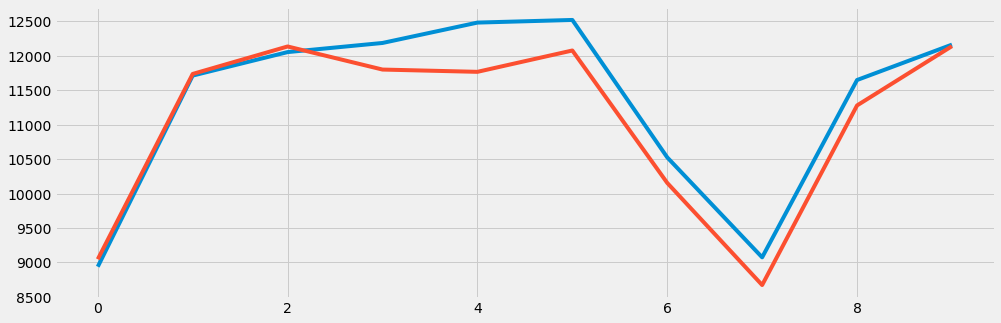

In [57]:
plt.figure()

plt.plot(test["var1(t)"].reset_index(drop = True))
plt.plot(predictions)

plt.show()

In [65]:
measures = get_measures(pd.Series(predictions), test["var1(t)"])
df_measures = pd.DataFrame([measures])
df_measures

,erro,mae,mse,rmse,mape,smape
0,1.311804e+06,292.251882,131180.40305,362.188353,0.025835,2.632413
